# EGR1 Binary Classifier

## Import libraries

In [49]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

from sklearn.linear_model import ElasticNet

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression

## Fetching the data

In [37]:
EGR1_PATH = "./data/GA"
def load_egr1_data(file_path = EGR1_PATH):
    return pd.read_csv(file_path, sep="\t")

GENE_MAP_PATH = "./data/probeMap-hugo_refgene_good_hg18_probemap"
def load_gene_mapping(file_path = GENE_MAP_PATH):
    return pd.read_csv(file_path, sep="\t")

In [38]:
egr1_data_pre = load_egr1_data()
egr1_data_pre.head()

,sample,TCGA-AB-2880-03,TCGA-AB-2819-03,TCGA-AB-2875-03,TCGA-AB-2808-03,TCGA-AB-2848-03,TCGA-AB-2841-03,TCGA-AB-2910-03,TCGA-AB-2920-03,TCGA-AB-2986-03,...,TCGA-AB-2946-03,TCGA-AB-2999-03,TCGA-AB-2938-03,TCGA-AB-2913-03,TCGA-AB-2810-03,TCGA-AB-2924-03,TCGA-AB-2937-03,TCGA-AB-2966-03,TCGA-AB-3012-03,TCGA-AB-2954-03
0,UBE2Q1,4.5844,4.9574,4.6304,4.6482,4.5685,4.6315,4.8461,4.9947,5.1369,...,4.7872,4.6204,4.9043,4.5906,5.1216,4.7572,5.0893,5.0708,4.5537,4.6225
1,HIF3A,0.0039,0.7462,0.6472,0.0305,0.0206,0.0000,0.0068,0.0105,0.0062,...,0.0000,0.0377,0.1892,0.0342,0.0230,0.0158,3.3688,0.0541,0.0171,0.0126
2,RNF17,0.0338,0.0201,0.0000,0.0260,0.0263,0.0205,0.0178,0.0119,0.0000,...,0.0259,0.0345,0.0053,0.0404,0.0335,0.0000,0.0240,0.0334,0.0009,0.0014
3,RNF10,5.9150,5.5003,5.6430,5.7971,6.0917,6.3663,5.6803,6.0212,5.5240,...,5.5981,5.6837,5.7704,5.6478,6.4578,5.6424,5.9336,5.4772,5.9701,5.3745
4,RNF11,4.1399,4.7407,4.1058,4.8867,4.0516,4.7545,4.2329,3.7790,4.6918,...,4.2740,4.6785,4.7170,4.5241,5.2825,4.2691,5.0298,5.0714,5.0994,3.9462


In [39]:
gene_map = load_gene_mapping()
gene_map.head()

,id,gene,chrom,chromStart,chromEnd,strand,thickStart,thickEnd,blockCount,blockSizes,blockStarts
0,LOC100506869,LOC100506869,chr12,57271751,57492717,+,57492718,57492717,2,"167,255","0,220712"
1,LOC102724604,LOC102724604,chr3,182621645,182642968,-,182642969,182642968,5,"298,189,102,58,113","0,565,17435,18814,21211"
2,MTVR2,MTVR2,chr17,52316462,52317273,-,52317274,52317273,1,812,0
3,LOC100506860,LOC100506860,chr7,130248763,130257245,+,130257246,130257245,4,"162,141,233,411","0,1498,2436,8072"
4,LOC102724601,LOC102724601,chr1,172357399,172395048,-,172395049,172395048,4,"149,71,104,124","0,33989,37249,37526"


In [32]:
egr1_data_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20113 entries, 0 to 20112
Columns: 180 entries, sample to TCGA-AB-2954-03
dtypes: float64(179), object(1)
memory usage: 27.6+ MB


## Converting the data

In [57]:
def convert_dataset(data):
    data = data.transpose()
    new_header = data.iloc[0]
    data = data[1:]
    data.columns = new_header
    return data

In [58]:
# test = convert_dataset(egr1_data)
egr1_data_converted = convert_dataset(egr1_data_pre)
egr1_data_converted.head()

sample,UBE2Q1,HIF3A,RNF17,RNF10,RNF11,RNF13,LOC339240,REM1,REM2,SLC17A2,...,AP4M1,TULP2,NPY5R,METTL11B,GNGT1,PTRF,SERPINH1,NFIX,SELP,SELS
TCGA-AB-2880-03,4.5844,0.0039,0.0338,5.915,4.1399,4.26,0.0,0.0,0.5026,0.0,...,2.9415,0.8686,0.0,0.0,0.0168,0.0804,1.5128,2.8916,0.6694,3.6215
TCGA-AB-2819-03,4.9574,0.7462,0.0201,5.5003,4.7407,4.1842,0.0,0.0,0.1909,0.0,...,2.9003,1.6265,0.0,0.0,0.0,0.8562,2.9365,3.8729,1.1842,4.3103
TCGA-AB-2875-03,4.6304,0.6472,0.0,5.643,4.1058,4.1313,0.0,0.0351,0.3683,0.0129,...,3.2132,1.0523,0.0,0.0,0.0267,0.4259,2.4843,3.835,2.308,3.8222
TCGA-AB-2808-03,4.6482,0.0305,0.026,5.7971,4.8867,4.5314,0.0,0.0421,0.4949,0.0,...,2.5941,0.2723,0.0,0.0,0.0,0.7469,1.5096,3.085,1.949,3.7343
TCGA-AB-2848-03,4.5685,0.0206,0.0263,6.0917,4.0516,4.3099,0.0,0.0,1.6417,0.0,...,3.2031,0.5258,0.0,0.0,0.0,0.1641,2.2657,3.2528,0.8104,3.9934


In [59]:
def get_percentile(data_col, per):
    top = np.percentile(data_col, per)
    bottom = np.percentile(data_col, 100 - per)
    return top, bottom

# 0 if top x percent
# 1 if bottom x percent
def convert_to_binary(data_col):
    if data_col <= BOTTOM_PERCENTILE:
        return 0
    elif data_col >= TOP_PERCENTILE:
        return 1
    else:
        return np.nan

In [60]:
data_egr1 = egr1_data_converted["EGR1"]

TOP_PERCENTILE, BOTTOM_PERCENTILE = get_percentile(data_egr1, 20)

binary_data_egr1 = data_egr1.apply(convert_to_binary)
egr1_data_converted.insert(0, "binary", binary_data_egr1)
egr1_data = egr1_data_converted.dropna()

In [61]:
egr1_data.head()
# egr1_data.tail()
# egr1_data.info()

sample,binary,UBE2Q1,HIF3A,RNF17,RNF10,RNF11,RNF13,LOC339240,REM1,REM2,...,AP4M1,TULP2,NPY5R,METTL11B,GNGT1,PTRF,SERPINH1,NFIX,SELP,SELS
TCGA-AB-2880-03,0,4.5844,0.0039,0.0338,5.915,4.1399,4.26,0.0,0.0,0.5026,...,2.9415,0.8686,0.0,0.0,0.0168,0.0804,1.5128,2.8916,0.6694,3.6215
TCGA-AB-2819-03,0,4.9574,0.7462,0.0201,5.5003,4.7407,4.1842,0.0,0.0,0.1909,...,2.9003,1.6265,0.0,0.0,0.0,0.8562,2.9365,3.8729,1.1842,4.3103
TCGA-AB-2875-03,0,4.6304,0.6472,0.0,5.643,4.1058,4.1313,0.0,0.0351,0.3683,...,3.2132,1.0523,0.0,0.0,0.0267,0.4259,2.4843,3.835,2.308,3.8222
TCGA-AB-2808-03,0,4.6482,0.0305,0.026,5.7971,4.8867,4.5314,0.0,0.0421,0.4949,...,2.5941,0.2723,0.0,0.0,0.0,0.7469,1.5096,3.085,1.949,3.7343
TCGA-AB-2848-03,0,4.5685,0.0206,0.0263,6.0917,4.0516,4.3099,0.0,0.0,1.6417,...,3.2031,0.5258,0.0,0.0,0.0,0.1641,2.2657,3.2528,0.8104,3.9934


## Separate training and testing sets

In [62]:
def get_xy_training_testing(dataframe):
    train_set, test_set = train_test_split(dataframe, test_size=0.4, random_state=42)
    X_train = train_set.drop("EGR1", axis=1)
    X_train = X_train.drop("binary", axis=1)
    X_test = test_set.drop("EGR1", axis=1)
    X_test = X_test.drop("binary", axis=1)
    y_train = train_set["binary"]
    y_test = test_set["binary"]
    return X_train, X_test, y_train, y_test
# len(train_set)
# len(test_set)

In [63]:
X_train, X_test, y_train, y_test = get_xy_training_testing(egr1_data)

In [64]:
print(y_train.head())

TCGA-AB-2848-03    0
TCGA-AB-3002-03    0
TCGA-AB-2990-03    1
TCGA-AB-2886-03    0
TCGA-AB-2938-03    0
Name: binary, dtype: int64


## Feature Selection 

In [66]:
# selectKBest = change hyperparameters 50-500, pass in the f-classify function
# this will give the x matrix
# will only accept and output numpy arrays
# getsupportmask (true false to mask panda arrays)
# put into decision tree
# present from google collab

X_new = SelectKBest(score_func=f_classif, k=50).fit(X_train, y_train)
X_bool = X_new.get_support()
X_n = X_train[X_train.columns[X_bool]]
X_n.head()

/Users/boosung/Documents/repos/egr1-binary-classifier/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   43   192   401   411   492   498   596   597   598   601   602   603
   606   607   620   694   770   816   817   818   978  1039  1230  1262
  1335  1347  1348  1350  1352  1364  1460  1490  1519  1558  1647  1692
  1727  1757  1779  1782  1819  1900  2068  2103  2295  2431  2463  2473
  2658  2682  2709  2757  2869  3001  3122  3126  3161  3162  3170  3338
  3477  3500  3516  3547  3549  3604  3658  3659  3684  3696  3787  3890
  4041  4063  4072  4074  4143  4145  4227  4243  4419  4423  4549  4557
  4600  4623  4626  4755  4815  4838  4869  4970  4998  5000  5050  5075
  5206  5207  5280  5310  5456  5470  5522  5523  5524  5526  5529  5532
  5554  5562  5717  5718  5720  5813  5968  6064  6151  6217  6236  6258
  6690  6730  6732  6887  6939  6959  7256  7302  7382  7440  7520  7543
  7628  7647  7658  7671  7763  

sample,RNF10,CHD7,BTG2,SORBS1,TPX2,TSSC1,DPYSL3,FTSJD2,C2orf29,COX7A1,...,RHOB,KLF2,SF3B3,BTBD19,APTX,ARHGEF4,EGR3,YARS,RAE1,GPR12
TCGA-AB-2848-03,6.0917,3.389,5.2655,0.2748,3.155,3.2025,2.9089,4.2315,4.8364,2.5641,...,4.7802,6.8961,5.0737,3.104,2.5936,0.3546,3.538,4.2338,3.4137,0.6293
TCGA-AB-3002-03,5.8369,1.0917,5.2734,0.3423,4.682,3.5535,1.8565,4.5111,4.9042,2.6072,...,3.8798,6.41,6.5357,2.307,2.5026,0.0664,2.2251,4.4901,4.1006,0.2306
TCGA-AB-2990-03,5.369,2.4167,5.9045,0.4003,5.4535,3.9614,3.7358,4.2027,4.9546,1.3647,...,6.2592,6.7748,5.9244,2.6044,3.2977,0.1164,1.207,4.961,3.995,2.4024
TCGA-AB-2886-03,5.6513,1.8293,2.9883,1.1484,4.4224,3.5145,0.0961,4.401,4.841,1.1693,...,4.1199,3.9104,6.2334,2.7563,3.5811,0.1668,0.1888,4.8791,3.6615,0.7128
TCGA-AB-2938-03,5.7704,2.7084,5.9244,1.9594,5.6794,3.8304,1.0218,4.1517,4.6779,1.4023,...,4.9561,4.4568,6.6808,1.1589,3.2483,0.1552,1.5039,5.372,3.2158,0.0


## SGDClassifier

In [67]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.30555556, 0.77777778, 0.45714286])

## Logistic Regression

### Logistic Regression Training

In [107]:
logistic_regr = LogisticRegression(random_state=42, max_iter=300)
logistic_regr.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=42)

In [108]:
predictions = logistic_regr.predict(X_test)

In [109]:
print(y_train)

TCGA-AB-2848-03    0
TCGA-AB-3002-03    0
TCGA-AB-2990-03    1
TCGA-AB-2886-03    0
TCGA-AB-2938-03    0
                  ..
TCGA-AB-2944-03    0
TCGA-AB-3011-03    1
TCGA-AB-2942-03    1
TCGA-AB-2835-03    0
TCGA-AB-2865-03    0
Name: binary, Length: 107, dtype: int64


### Logistic Regression Scoring

In [110]:
score = logistic_regr.score(X_train, y_train)
print(score)
score = logistic_regr.score(X_test, y_test)
print(score)

1.0
0.8611111111111112


### Logistic Regression Feature Importance

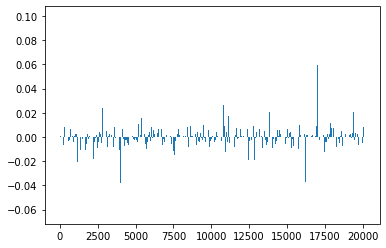

In [21]:
importance = logistic_regr.coef_[0]
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Decision Tree

### Decision Tree Training

In [77]:
clf = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=30, min_samples_split=20, min_samples_leaf=10)
# min_samples_split=5-7
# min_samples_leaf=10
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=30, min_samples_leaf=10,
                       min_samples_split=20)

[Text(167.4, 190.26, 'X[16120] <= 6.12\ngini = 0.337\nsamples = 107\nvalue = [84, 23]'),
 Text(83.7, 135.9, 'X[4545] <= 0.461\ngini = 0.156\nsamples = 82\nvalue = [75, 7]'),
 Text(41.85, 81.53999999999999, 'gini = 0.49\nsamples = 14\nvalue = [8, 6]'),
 Text(125.55000000000001, 81.53999999999999, 'X[10902] <= 4.054\ngini = 0.029\nsamples = 68\nvalue = [67, 1]'),
 Text(83.7, 27.180000000000007, 'gini = 0.18\nsamples = 10\nvalue = [9, 1]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 58\nvalue = [58, 0]'),
 Text(251.10000000000002, 135.9, 'X[12490] <= 0.361\ngini = 0.461\nsamples = 25\nvalue = [9, 16]'),
 Text(209.25, 81.53999999999999, 'gini = 0.426\nsamples = 13\nvalue = [9, 4]'),
 Text(292.95, 81.53999999999999, 'gini = 0.0\nsamples = 12\nvalue = [0, 12]')]

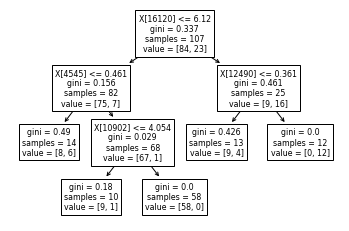

In [78]:
plot_tree(clf)

### Decision Tree Scoring

In [79]:
train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)

In [80]:
print("Training accuracy: ", accuracy_score(y_train, train_predict))
print("Test accuracy: ", accuracy_score(y_test, test_predict))

Training accuracy:  0.897196261682243
Test accuracy:  0.8055555555555556


In [82]:
clf2 = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=30, min_samples_split=20, min_samples_leaf=10)
clf2.fit(X_n, y_train)

train_predict2 = clf2.predict(X_n)
test_predict2 = clf2.predict(X_test)

print("Training accuracy: ", accuracy_score(y_train, train_predict2))
print("Test accuracy: ", accuracy_score(y_test, test_predict2))

ValueError: X has 20112 features, but DecisionTreeClassifier is expecting 50 features as input.

### Decision Tree Feature Importance

In [219]:
feature_df = pd.DataFrame({"Feature_names": X_test.columns, "Importances": clf.feature_importances_})
feature_df.sort_values(by="Importances", ascending=False)

,Feature_names,Importances
16120,RHOB,0.537825
12490,RRH,0.272923
4545,HLA-DQB2,0.181468
13167,RPA4,0.007784
0,UBE2Q1,0.000000
...,...,...
6704,SFTPD,0.000000
6703,EEPD1,0.000000
6702,C20orf111,0.000000
6701,GAPT,0.000000


## Elastic Net

In [244]:
elastic_net = ElasticNet(alpha=0.2, l1_ratio=0.1)
elastic_net.fit(X_train, y_train)
el_train_predict = elastic_net.predict(X_train)
el_test_predict = elastic_net.predict(X_test)

In [245]:
el_score_train = elastic_net.score(X_train, y_train)
print(el_score_train)
el_score_test = elastic_net.score(X_test, y_test)
print(el_score_test)

0.8785919377936495
0.22402276787843578


## Correlation Filter

In [ ]:
# selectKBest = change hyperparameters 50-500, pass in the f-classify function
# this will give the x matrix
# will only accept and output numpy arrays
# getsupportmask (true false to mask panda arrays)
# put into decision tree
# present from google collab

